# Samtools stats per read


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/error_rate")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")


In [2]:
def grep_file(file, key, columns=None):
    data = []
    with open(file) as f:
        for line in f:
            if line.startswith(key):
                data.append(line.strip().split("\t")[1:])

    if columns:
        data = pd.DataFrame(data, columns=columns)
    else: 
        data = pd.DataFrame(data)
    return data

def files():
    runs = ["aviti_ngi", "aviti_hq", "xplus_sns"]
    cells = ["KMS12BM", "MM1S", "OPM2", "REH"]
    reads = ["R1", "R2"]
    for run in runs:
        for cell in cells:
            for read in reads:
                file = basedir / f"samtools_stats/{run}/{cell}_{read}_chr20_stats.txt"
                yield run, cell, read, file

def files_filt():
    runs = ["aviti_ngi", "aviti_hq", "xplus_sns"]
    cells = ["KMS12BM", "MM1S", "OPM2"]
    reads = ["R1", "R2"]
    for run in runs:
        for cell in cells:
            for read in reads:
                file = basedir / f"samtools_stats_filt/{run}/{cell}_{read}_chr20_stats.txt"
                yield run, cell, read, file


## Substitutions

In [3]:
data = []
for run, cell, read, file in files():
    key = "FFQ" if read == "R1" else "LFQ"
    d = grep_file(file, key)
    d = d.astype({c: int for c in d.columns})
    quals = list(range(0,d.shape[1]-1))
    columns = ["Cycle"] + quals
    d.columns = columns
    d["CycleRaw"] = d["Cycle"]
    if read == "R2":
        d["Cycle"] += 150

    d["AverageQ"] = d[quals].dot(np.array(quals)) / d[quals].sum(axis=1)
    d["Bases"] = d[quals].sum(axis=1)
    d["MeanError"] = np.sum(d[quals] * (10 ** (-np.array(quals)/10)), axis=1) / d[quals].sum(axis=1)
    d["MeanErrorQ"] = d["MeanError"].apply(lambda x: -10*np.log10(x))
    
    
    m = grep_file(file, "MPC")
    m = m.astype({c: int for c in m.columns})
    quals = list(range(0,m.shape[1]-2))
    columns = ["Cycle", "N"] + quals
    m.columns = columns
        
    d[quals] = m[quals] / d[quals]
    d["Mismatches"] = m[quals].sum(axis=1)
    d["Mismatches per base"] = 100 *  d["Mismatches"] / d["Bases"] 
    d["Read"] = read
    d["Run"] = run
    d["Cell line"] = cell
    #d = d.drop(columns=quals)
    data.append(d)

data = pd.concat(data).reset_index()
data = data.fillna(0.0)
data["Data source"] = data["Run"].replace(run_names)

# Normalize data across cell lines and make minimum zero
data["Mismatches per base norm"] = data.groupby(["Cell line"])["Mismatches per base"].transform(lambda x: x - x.median())

# Smooth data
data["Mismatches per base smoothed"] = data.groupby(["Run", "Cell line", "Read"])["Mismatches per base"].transform(
    lambda x: x.rolling(5, center=True).mean()
)
# Smooth data
data["Mismatches per base norm smoothed"] = data.groupby(["Run", "Cell line", "Read"])["Mismatches per base norm"].transform(
    lambda x: x.rolling(5, center=True).mean()
)

data

,index,Cycle,0,1,2,3,4,5,6,7,...,MeanErrorQ,Mismatches,Mismatches per base,Read,Run,Cell line,Data source,Mismatches per base norm,Mismatches per base smoothed,Mismatches per base norm smoothed
0,0,1,0.0,0.0,0.0,0.500000,0.390625,0.271429,0.360465,0.226415,...,36.196491,7127,0.154167,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.094949,NaN,NaN
1,1,2,0.0,0.0,0.0,0.483871,0.416667,0.272727,0.360000,0.239130,...,26.947015,6007,0.129940,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.119176,NaN,NaN
2,2,3,0.0,0.0,0.0,0.434783,0.310345,0.119048,0.238095,0.136364,...,38.408489,5063,0.109520,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.139596,0.123969,-0.125146
3,3,4,0.0,0.0,0.0,0.480000,0.357143,0.245902,0.285714,0.129032,...,39.346297,5131,0.110991,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.138125,0.119937,-0.129178
4,4,5,0.0,0.0,0.5,0.478571,0.257143,0.329032,0.185567,0.147287,...,37.726312,5327,0.115230,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.133885,0.124272,-0.124843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,145,296,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.927219,82845,0.641864,R2,xplus_sns,REH,NovaSeqX+,0.376138,0.686689,0.420964
3596,146,297,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.792624,87201,0.675613,R2,xplus_sns,REH,NovaSeqX+,0.409887,0.693136,0.427410
3597,147,298,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.709624,90932,0.704520,R2,xplus_sns,REH,NovaSeqX+,0.438794,0.704844,0.439118
3598,148,299,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.646021,93432,0.723890,R2,xplus_sns,REH,NovaSeqX+,0.458164,NaN,NaN


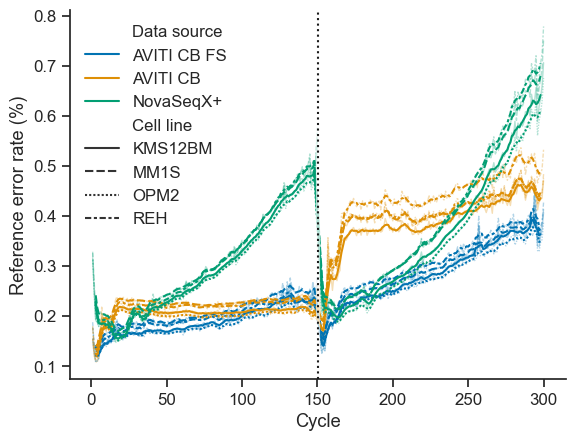

In [4]:
ax = sns.lineplot(data, x="Cycle", y="Mismatches per base", hue="Data source", units="Read", 
                 style="Cell line", alpha=0.3, legend=False, lw=1, hue_order=run_names.values())
ax = sns.lineplot(data, x="Cycle", y="Mismatches per base smoothed", hue="Data source", hue_order=run_names.values(),
                 style="Cell line")
ax.set_ylabel("Reference error rate (%)")
ax.legend(frameon=False, framealpha=0)
ax.axvline(150.5, color="k", ls=":", zorder=3)
ax.axvline(150.5, color="w", lw=3, alpha=0.7, zorder=2)
fig = ax.get_figure()
fig.savefig(figdir / "error_rate_vs_reference_by_cycle.svg")

## Substitutions + Indels

In [5]:
datai = []
for run, cell, read, file in files():
    key = "FFQ" if read == "R1" else "LFQ"
    d = grep_file(file, key)
    d = d.astype({c: int for c in d.columns})
    quals = list(range(0,d.shape[1]-1))
    columns = ["Cycle"] + quals
    d.columns = columns
    if read == "R2":
        d["Cycle"] += 150

    d["AverageQ"] = d[quals].dot(np.array(quals)) / d[quals].sum(axis=1)
    
    d["Bases"] = d[quals].sum(axis=1)
    d = d.drop(columns=quals)
    
    m = grep_file(file, "MPC")
    m = m.astype({c: int for c in m.columns})
    quals = list(range(0,m.shape[1]-2))
    columns = ["Cycle", "N"] + quals
    m.columns = columns

    d["Substitutions"] = m[quals].sum(axis=1)
    d["Substitutions per base"] = 100 * d["Substitutions"] / d["Bases"] 

    # IC reports the frequency of indels occurring per cycle, broken down by both 
    # insertion / deletion and by first / last read. Note for multi-base indels 
    # this only counts the first base location. Columns are cycle, number of 
    # insertions in first fragments, number of insertions in last fragments, 
    # number of deletions in first fragments, and number of deletions in last fragments.
    ic = grep_file(file, "IC")
    ic = ic.astype({c: int for c in ic.columns})
    columns = ["Cycle", "InsR1", "InsR2", "DelR1", "DelR2"]
    ic.columns = columns

    indel_cols = ["InsR1", "DelR1"] if read == "R1" else ["InsR2", "DelR2"]
    d["Indels"] = ic[indel_cols].sum(axis=1)
    d["Indels per base"] = 100 * d["Indels"] / d["Bases"]

    d["Ins"] = ic[indel_cols[0]]
    d["Del"] = ic[indel_cols[1]]
    
    d["Mismatches"] = d[["Substitutions","Indels"]].sum(axis=1)
    d["Mismatches per base"] = 100 * d["Mismatches"] / d["Bases"]
    
    d["Read"] = read
    d["Run"] = run
    d["Cell line"] = cell
    datai.append(d)

datai = pd.concat(datai).reset_index()
datai = datai.fillna(0.0)
datai["Data source"] = datai["Run"].replace(run_names)
datai

,index,Cycle,AverageQ,Bases,Substitutions,Substitutions per base,Indels,Indels per base,Ins,Del,Mismatches,Mismatches per base,Read,Run,Cell line,Data source
0,0,1,37.299037,4622912,7127,0.154167,207.0,0.004478,0.0,207.0,7334.0,0.158645,R1,aviti_ngi,KMS12BM,AVITI CB FS
1,1,2,42.334874,4622912,6007,0.129940,481.0,0.010405,242.0,239.0,6488.0,0.140344,R1,aviti_ngi,KMS12BM,AVITI CB FS
2,2,3,42.394971,4622912,5063,0.109520,519.0,0.011227,283.0,236.0,5582.0,0.120746,R1,aviti_ngi,KMS12BM,AVITI CB FS
3,3,4,42.357160,4622912,5131,0.110991,565.0,0.012222,296.0,269.0,5696.0,0.123212,R1,aviti_ngi,KMS12BM,AVITI CB FS
4,4,5,42.281821,4622912,5327,0.115230,693.0,0.014991,356.0,337.0,6020.0,0.130221,R1,aviti_ngi,KMS12BM,AVITI CB FS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,145,296,37.648591,12906941,82845,0.641864,1389.0,0.010762,571.0,818.0,84234.0,0.652626,R2,xplus_sns,REH,NovaSeqX+
3596,146,297,37.585293,12906941,87201,0.675613,0.0,0.000000,0.0,0.0,87201.0,0.675613,R2,xplus_sns,REH,NovaSeqX+
3597,147,298,37.542535,12906941,90932,0.704520,0.0,0.000000,0.0,0.0,90932.0,0.704520,R2,xplus_sns,REH,NovaSeqX+
3598,148,299,37.508948,12906941,93432,0.723890,0.0,0.000000,0.0,0.0,93432.0,0.723890,R2,xplus_sns,REH,NovaSeqX+


<Axes: xlabel='Data source', ylabel='Error rate (%)'>

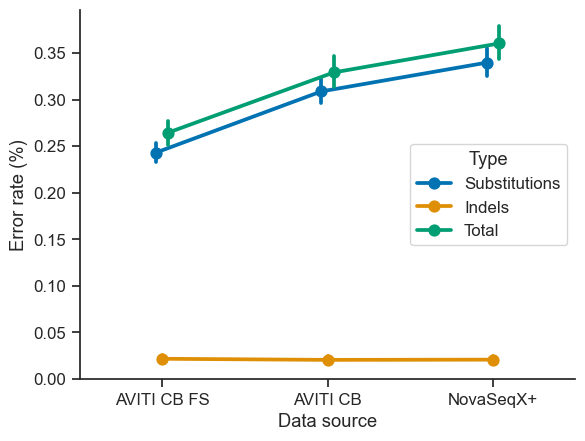

In [6]:

d = datai.copy()
d = d.melt(id_vars=["Data source", "Cell line"], value_vars=["Substitutions per base", "Indels per base", "Mismatches per base"],
           var_name="Type", value_name="Error rate (%)")

# Rename type
d["Type"] = d["Type"].replace({
    "Substitutions per base": "Substitutions",
    "Indels per base": "Indels",
    "Mismatches per base": "Total"
})

sns.pointplot(d, x="Data source", y="Error rate (%)", hue="Type", 
                palette="colorblind", dodge=True, units="Cell line",)
